In [4]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt

from torch.distributions import Categorical, Normal

from sklearn.metrics import confusion_matrix, classification_report

from core import Critic, Actor, Episode, ReplayBuffer
from ud_sac import sample_episode

# Critic test

In [5]:
def _critic_loss(critic, num_classes, state, command, action, reward, next_state, done, output):
    with torch.no_grad():
        next_command = torch.zeros_like(command)

        next_command[:, 0] = command[:, 0] - reward
        next_command[:, 1] = torch.max(command[:, 1] - 1, torch.ones_like(command[:, 1]))

        next_action = critic.log_prob_by_action(next_state, next_command, next_command).argmax(dim=1)
        next_action = F.one_hot(next_action.long(), num_classes=num_classes)

        next_output = critic.sample(next_state, next_action, next_command)
        next_output[:, 1] = torch.round(next_output[:, 1])
        
        target_output = next_output + torch.cat([reward.view(-1, 1), torch.ones_like(reward).view(-1, 1)], dim=-1)

    Q_done = critic.log_prob(state, action, command, output)
    Q_not_done = critic.log_prob(state, action, command, target_output)        
    loss = -(done * Q_done + (1 - done) * Q_not_done).mean() # NLL

    return loss


def sample_random_batch(env_name, warmup_episodes=100, buffer_size=100, batch_size=2048):    
    env = gym.make(env_name)
    buffer = ReplayBuffer(size=buffer_size)
    
    for _ in range(warmup_episodes):
        episode = sample_episode(env, None, None)
        buffer.add(episode)
      
    batch = buffer.sample(batch_size)

    states, actions, rewards, commands, next_states, dones, outputs = [], [], [], [], [], [], []

    for episode in batch:
        T = episode.length

        t1 = np.random.randint(0, T)
        t2 = int(T) # take only full run
        dr = np.sum(episode.rewards[t1:t2])
        dh = t2-t1

        states.append(episode.states[t1])
        actions.append(episode.actions[t1])
        rewards.append(episode.rewards[t1])
        commands.append(episode.commands[t1])
        next_states.append(episode.next_states[t1])
        dones.append(episode.dones[t1])
        outputs.append([dr, dh])
    
    return [states, commands, actions, rewards, next_states, dones, outputs]

In [6]:
state, command, action, reward, next_state, done, output = sample_random_batch("LunarLander-v2")

state = torch.tensor(state, dtype=torch.float32)
command = torch.tensor(command, dtype=torch.float32)

action = torch.tensor(action, dtype=torch.float32)
action = F.one_hot(action.long(), num_classes=4)

reward = torch.tensor(reward, dtype=torch.float32)
next_state = torch.tensor(next_state, dtype=torch.float32)
done = torch.tensor(done, dtype=torch.float32)
output = torch.tensor(output, dtype=torch.float32)

In [8]:
command.mean(dim=0), output.mean(dim=0)

(tensor([-141.2278,   49.5210]), tensor([-137.4899,   49.5044]))

In [9]:
critic = Critic(8, 4, 2, n_heads=20)
critic_optim = torch.optim.Adam(critic.parameters())

In [10]:
for epoch in range(5000):    
    loss = critic.nll_loss(state, command, action, output)
#     loss = _critic_loss(critic, 4, state, command, action, reward, next_state, done, output)
    
    if epoch % 100 == 0:
        print(loss.item())
    
    critic_optim.zero_grad()
    loss.backward()
    critic_optim.step()

229.66201782226562
11.465880393981934
10.708613395690918
10.15345287322998
9.981322288513184
9.838811874389648
9.7390718460083
9.643625259399414
9.596160888671875
9.54815673828125
9.50013256072998
9.457552909851074
9.409387588500977
9.360332489013672
9.30810260772705
9.245931625366211
9.191963195800781
9.118945121765137
9.075522422790527
8.993927001953125
8.93842887878418
8.8368501663208
8.759873390197754
8.68912124633789
8.666814804077148
8.5247802734375
8.451568603515625
8.637567520141602
8.731279373168945
8.437400817871094
8.292195320129395
8.199259757995605
8.260308265686035
8.138406753540039
8.270167350769043
8.054004669189453
9.093026161193848
8.484622955322266
8.386857032775879
8.305559158325195
8.258179664611816
8.248619079589844
8.226901054382324
8.191682815551758
8.173508644104004
8.151312828063965
8.181157112121582
8.084867477416992
8.061389923095703
8.16285228729248


tensor([-131.2529,   73.5710])


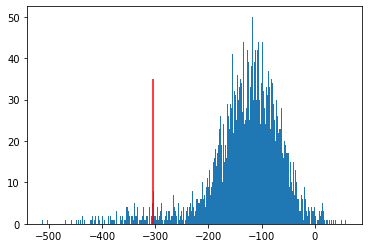

In [11]:
sample = [critic.sample(state[1].unsqueeze(0), command[1].unsqueeze(0), action[1].unsqueeze(0)) for _ in range(5000)]

print(torch.cat(sample).mean(dim=0))

plt.hist(torch.cat(sample)[:, 0].numpy(), bins=600);
plt.vlines(output[1][0], 0, 35, colors="red");

In [12]:
def episode_stats(env_name, critic, actor=None, controller=None):
    episode = sample_episode(gym.make(env_name), actor, controller)

    state = torch.tensor(episode.states, dtype=torch.float32)
    command = torch.tensor(episode.commands, dtype=torch.float32)

    action = torch.tensor(episode.actions, dtype=torch.float32)
    action = F.one_hot(action.long(), num_classes=4)
    
    episode_x = torch.cat([state, command, action], dim=1)

    log_alpha, mu, sigma = critic.model(episode_x)

    for i in range(int(episode.length)):
        output_h = int(episode.length) - i
        output_r = np.sum(episode.rewards[i:])

        pred_mean = critic.mean(state[i].unsqueeze(0), command[i].unsqueeze(0), action[i].unsqueeze(0))[0]
            
        print(f"Step {i} " + "=" * 50)
        print(f"Outcome: {[output_r, output_h]}") 
        print(f"Predicted outcome means: {pred_mean.detach().numpy()}")
        print(f"Mixture means:\n {mu[i].detach().numpy()}")
        print(f"Mixture stds:\n {sigma[i].detach().numpy()}")
        print()

In [13]:
# %%capture cap --no-stderr
episode_stats(env_name="LunarLander-v2", critic=critic)

Step 0 ==================================================
Outcome: [-108.15570531636021, 116]
Predicted outcome means: [-154.51453   88.36   ]
Mixture means:
 [[  12.204318    -5.134562 ]
 [  16.628662    -4.3117743]
 [  -7.8204117   19.606724 ]
 [  -3.225202    17.41897  ]
 [ -30.356953    -1.6572573]
 [ -32.937973    41.12258  ]
 [-190.29662      6.338353 ]
 [-325.8316      79.59048  ]
 [-432.6642      14.315405 ]
 [  -0.9596129    8.652352 ]
 [-131.07683     65.59856  ]
 [-183.5423      36.821064 ]
 [-125.90633     89.562485 ]
 [   2.2467277   11.773482 ]
 [   5.120866    -6.5958357]
 [  -0.5072285    5.638382 ]
 [   1.3803916   -2.5420942]
 [-329.73407     96.93802  ]
 [   3.021151    -1.026995 ]
 [-210.15671     43.093967 ]]
Mixture stds:
 [[1.3533528e-01 1.4348070e+01]
 [3.3218317e+02 1.3533528e-01]
 [1.3533528e-01 3.9564881e-01]
 [1.3533528e-01 1.3533528e-01]
 [4.8516518e+08 1.3533528e-01]
 [4.8516518e+08 4.8516518e+08]
 [1.3533528e-01 4.9390727e+04]
 [5.6154625e+01 2.1200368e+0

Predicted outcome means: [-111.70509   68.83185]
Mixture means:
 [[ 1.1267139e+01 -4.2107744e+00]
 [ 1.4810521e+01 -4.6653876e+00]
 [-6.2808189e+00  1.7172531e+01]
 [-3.0483534e+00  1.9289665e+01]
 [-2.8999771e+01 -8.8051742e-01]
 [-3.2528511e+01  4.3011639e+01]
 [-1.8658237e+02  7.2012386e+00]
 [-2.4753658e+02  7.1485474e+01]
 [-4.0105692e+02  1.1416705e+01]
 [-1.7663646e-01  3.9247377e+00]
 [-1.2447265e+02  5.1917202e+01]
 [-1.8376555e+02  2.9610088e+01]
 [-1.1162148e+02  6.8830017e+01]
 [ 5.1505037e-02  1.1137471e+01]
 [ 4.0153995e+00 -5.1544390e+00]
 [-2.3030338e+00  6.2456274e+00]
 [-3.8697305e-01 -2.5068760e+00]
 [-2.4396844e+02  7.8794830e+01]
 [ 8.5348743e-01 -2.1125672e+00]
 [-2.2109564e+02  3.9226524e+01]]
Mixture stds:
 [[1.3533528e-01 1.7778923e+02]
 [8.6640240e+02 1.3533528e-01]
 [1.3533528e-01 1.8337677e+00]
 [1.3533528e-01 1.3533528e-01]
 [4.8516518e+08 1.3533528e-01]
 [4.8516518e+08 4.8516518e+08]
 [1.3533528e-01 3.6108734e+01]
 [1.7095769e+02 1.4232330e+01]
 [1.8223405

Step 75 ==================================================
Outcome: [-103.25492984982684, 41]
Predicted outcome means: [-108.371254   41.75975 ]
Mixture means:
 [[ 1.07137098e+01 -3.11095142e+00]
 [ 1.41736631e+01 -5.19591808e+00]
 [-5.15577030e+00  1.44592934e+01]
 [-3.03208876e+00  1.96893826e+01]
 [-2.96458855e+01 -8.16344976e-01]
 [-3.24586945e+01  4.67360115e+01]
 [-1.89787720e+02  6.45499706e+00]
 [-1.89420898e+02  5.90493584e+01]
 [-3.84008911e+02  9.70300388e+00]
 [-2.20905632e-01 -1.03136599e+00]
 [-1.25673737e+02  3.41581001e+01]
 [-1.85770370e+02  2.05329437e+01]
 [-1.08346825e+02  4.17545509e+01]
 [-1.93792748e+00  1.23132238e+01]
 [ 2.40024781e+00 -3.86995173e+00]
 [-3.87836146e+00  6.27109528e+00]
 [-1.94390178e+00 -2.15572214e+00]
 [-1.99592407e+02  5.86156197e+01]
 [-6.43368661e-01 -3.62130165e+00]
 [-2.40185974e+02  3.46520042e+01]]
Mixture stds:
 [[1.3533528e-01 2.9630139e+02]
 [2.0097859e+03 1.3533528e-01]
 [1.3533528e-01 1.9900706e+00]
 [1.3533528e-01 1.3533528e-01]

Mixture means:
 [[   7.875423    -1.5713536]
 [  12.25824     -3.564139 ]
 [  -3.2775311   11.6365795]
 [  -1.0573364   17.775995 ]
 [ -27.844927    -1.0543163]
 [ -24.08824     41.73627  ]
 [-176.49182      5.7899747]
 [-145.55731     41.37661  ]
 [-343.4957       5.3320813]
 [  -0.7109662   -3.5819538]
 [-105.18074     -3.4792333]
 [-165.2478      19.651154 ]
 [ -89.22575      5.682044 ]
 [  -4.859264    13.092646 ]
 [   0.8025298   -2.4754384]
 [  -4.9091363    6.9268465]
 [  -1.4533936   -1.5344222]
 [-139.16888     36.508835 ]
 [  -1.9111365   -6.165753 ]
 [-221.76889     29.28586  ]]
Mixture stds:
 [[1.3533528e-01 1.1197217e+03]
 [1.7546566e+04 1.3533528e-01]
 [1.3533528e-01 3.6313291e+00]
 [1.3533528e-01 1.3533528e-01]
 [5.5598872e+07 1.3533528e-01]
 [4.8516518e+08 1.8372300e+07]
 [8.2215136e-01 8.5932283e+00]
 [3.4389941e+02 1.4865765e+01]
 [1.3533528e-01 1.3533528e-01]
 [1.3533528e-01 1.4278944e+05]
 [5.7960045e+01 1.7357811e+04]
 [7.0463767e+00 4.3632035e+00]
 [1.4361090e+01 

In [14]:
def rollout(actor, desired_return, desired_horizon):
    env = gym.make("LunarLander-v2")

    state, done = env.reset(), False
    
    total_return, steps = 0.0, 0.0
    while not done:
        command = np.array([desired_return, desired_horizon])
        
        action = actor.act(state, command)
        state, reward, done, _ = env.step(action)
        
        desired_return = min(desired_return - reward, env.reward_range[1])
        desired_horizon = max(desired_horizon - 1, 1)
        
        total_return += reward
        steps += 1
        
    return total_return, steps

# Actor test

In [32]:
def _actor_loss(actor, critic, state, command):
    _, action_probs, action_log_probs = actor(state, command, return_probs=True)
    Q_target = critic.log_prob_by_action(state, command, output=command)

    loss = ((0.2 * action_log_probs - Q_target.detach()) * action_probs).sum(dim=1).mean()

    return loss

In [36]:
actor = Actor(8, 4)
actor_optim = torch.optim.Adam(actor.parameters())

In [37]:
for epoch in range(5000):    
#     actor_loss_c = _actor_loss(actor, critic, state, command)
    actor_loss_o = _actor_loss(actor, critic, state, output)
    
    if epoch % 100 == 0:
        print(actor_loss_o.item())
    
    actor_optim.zero_grad()
    actor_loss_o.backward()
    actor_optim.step()

19.042081832885742
18.812252044677734
18.75533676147461
18.735219955444336
18.719545364379883
18.710628509521484
18.707406997680664
18.704862594604492
18.70273780822754
18.700260162353516
18.699264526367188
18.69497299194336
18.69367790222168
18.693397521972656
18.69244956970215
18.69167137145996
18.691457748413086
18.69139289855957
18.690303802490234
18.68988609313965
18.689451217651367
18.688232421875
18.688671112060547
18.686573028564453
18.68597412109375
18.686443328857422
18.686153411865234
18.685136795043945
18.685504913330078
18.685998916625977
18.685304641723633
18.68487548828125
18.68443489074707
18.684856414794922
18.684463500976562
18.684375762939453
18.684640884399414
18.684024810791016
18.684717178344727
18.683889389038086
18.68439483642578
18.683826446533203
18.68396759033203
18.68411636352539
18.68378448486328
18.6842098236084
18.68349838256836
18.683944702148438
18.68377113342285
18.683685302734375


In [38]:
# confusion_matrix(critic.log_prob_by_action(state, command, command).argmax(dim=1).numpy(), actor(state, command).numpy())

confusion_matrix(critic.log_prob_by_action(state, output, output).argmax(dim=1).numpy(), actor(state, output).numpy())

array([[333,  97,  51,  72],
       [194, 318,  81, 124],
       [ 83,  54, 264,  73],
       [ 40,  37,  37, 190]])

In [39]:
# print(classification_report(critic.log_prob_by_action(state, command, command).argmax(dim=1).numpy(), actor(state, command).numpy()))

print(classification_report(critic.log_prob_by_action(state, output, output).argmax(dim=1).numpy(), actor(state, output).numpy()))

              precision    recall  f1-score   support

           0       0.51      0.59      0.55       553
           1       0.60      0.43      0.50       717
           2       0.60      0.55      0.58       474
           3       0.40      0.61      0.48       304

    accuracy                           0.53      2048
   macro avg       0.53      0.54      0.53      2048
weighted avg       0.55      0.53      0.53      2048



In [40]:
class TestActor:
    def __init__(self, actor):
        self.actor = actor
        
    def act(self, state, command, eval_mode=False):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32)
            command = torch.tensor(command, dtype=torch.float32) 

            action = self.actor(state, command, eval_mode=eval_mode)
            
        return action.cpu().numpy().item()

In [41]:
test_actor = TestActor(actor)

In [42]:
desired_rewards = np.sort(np.random.uniform(-200, -100, size=500))

In [43]:
rewards = [np.mean([rollout(test_actor, r, 50)[0] for _ in range(5)]) for r in desired_rewards]

Text(0, 0.5, 'Actual rewards')

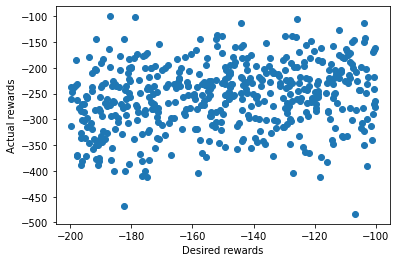

In [44]:
plt.scatter(desired_rewards, rewards)
plt.xlabel("Desired rewards")
plt.ylabel("Actual rewards")